# GAN Mask-RCNN

### The following code demonstrates how to use GAN based approach to improve instance segmentation in images, starting from a pre-trained Mask-RCNN instance segmentation model the goal is to use a Generative Adversarial Network (GAN) where Mask-RCNN becomes the generator network and in opposition a discriminator network is responsible to distinguish between generated masks and real masks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1 - Mask RCNN finetuning

The first stage consists into finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

the first steps of this notebook come from pytorch finetuning Mask-RCNN tutorial that shows how to tune and use a Mask-RCNN model to make predictions

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-wsex7c60
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-wsex7c60
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263915 sha256=44745a3df9eaba929589d6ed193fa3d58c460fed76d8292c0f811769a9070a7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-r96sikel/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Penn-Fudan

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2021-05-12 10:50:50--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  98.9MB/s    in 0.5s    

2021-05-12 10:50:51 (98.9 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-05-12 10:50:51--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-05-12 10:50:51--
Total wall clock time: 0.6s
Downloaded: 1 files, 51M in 0.5s (98.9 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FBAE1E825D0>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 23991, done.
remote: Counting objects: 100% (1460/1460), done.
remote: Compressing objects: 100% (424/424), done.
remote: Total 23991 (delta 1045), reused 1364 (delta 1004), pack-reused 22531
Receiving objects: 100% (23991/23991), 31.62 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (17744/17744), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

dataset_train = torch.utils.data.Subset(dataset, indices[:75])

# dataset test is used as dataset in adversarial approach 
dataset_evaluation = torch.utils.data.Subset(dataset_test, indices[150:170])

dataset_test = torch.utils.data.Subset(dataset_test, indices[75:150])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_evaluation = torch.utils.data.DataLoader(
    dataset_evaluation, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


#### now that the model structure is defined, it can be trained by scratch or loaded from a directory in case a trained model already exists

In [ ]:
# ### load pretrained model
# # --------- load with disctionary load:

# epoch = 9 # last epoch for ehich the model was saved
# #PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/generator_pennfudan_75imgs_epoch"+str(epoch)
# PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/generator_pennfudan_75imgs_dataB_epoch"+str(epoch)

# model = get_instance_segmentation_model(num_classes)
# # move model to the right device
# model.to(device)
# # construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)

# checkpoint = torch.load(PATH, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# #loss = checkpoint['loss']

# model.train() # set the model in training mode

# print("model loaded")

model loaded


And now let's train the model 

In [ ]:
# if the following is commented, it means the model has already been trained and saved

# let's train it
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    #train_one_epoch(model, optimizer, data_loader_test, device, epoch, print_freq=10) # train on dataB
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset



## Saving & Loading Model for Inference


### Save

In [ ]:
# # PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/generator_pennfudan_50imgs_epoch"+str(epoch)
# PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/generator_pennfudan_100%_epoch"
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             #'loss': loss,
#             }, PATH+str(epoch))

The code below evaluate the trained model saving the Average Precision and Average Recall results in a text file

In [ ]:
# """Evaluate the model"""
# import sys
# original_stdout = sys.stdout # Save a reference to the original standard output

# FILENAME = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/results/PennFudan/"

# # evaluate model performances
# with open(FILENAME+'base_mask_100%_epoch_'+str(epoch)+'.txt', 'w') as f: # for base maskrcnn model

#     sys.stdout = f # Change the standard output to the file we created.
#     # # evaluate model on evaluation dataset
#     evaluate(model, data_loader_evaluation, device=device)
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [ ]:
# setup GPU if available

GPU = False
if torch.cuda.is_available():
  GPU = True

## Now train with data B
in this case the model is trained with a second part of the dataset

In [ ]:
# # Commented because the model has already been trained and saved

# # let's train it
# num_epochs = 10

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, data_loader_test, device, epoch, print_freq=10) # train on dataB
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset

In [ ]:
# PATH_B = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/generator_pennfudan_75imgs_dataB_epoch"
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             #'loss': loss,
#             }, PATH_B+str(epoch))

In [ ]:
# """Evaluate the model"""
# import sys

# original_stdout = sys.stdout # Save a reference to the original standard output

# FILENAME = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/results/PennFudan/"

# # evaluate model performances
# with open(FILENAME+'base_mask_dataB_epoch_'+str(epoch)+'.txt', 'w') as f: # for base maskrcnn model

#     sys.stdout = f # Change the standard output to the file we created.
#     # # evaluate model on evaluation dataset
#     evaluate(model, data_loader_evaluation, device=device)
#     sys.stdout = original_stdout # Reset the standard output to its original value

#### Load

In [ ]:
# # --------- load with disctionary load:

# epoch = 1 # last epoch for ehich the model was saved
# PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/generator_pennfudan_50imgs_epoch"+str(epoch)

# model = get_instance_segmentation_model(num_classes)
# optimizer = optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)

# checkpoint = torch.load(PATH, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# #loss = checkpoint['loss']

# # model.eval()
# # - or -
# model.train()

# print("model loaded")

Check that the model has trainable parameters

In [ ]:
# for param in model.parameters():
#     param.requires_grad = True

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# pick one image from the test set
img, targets = dataset_test[4]

# put the model in evaluation mode
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
# prediction

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

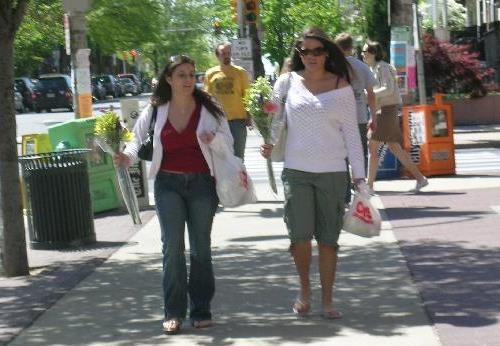

In [ ]:
PIL_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
PIL_image.save("/content/PIL_image.jpg")
PIL_image

In [ ]:
img_cv =  cv2.imread('/content/PIL_image.jpg')

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

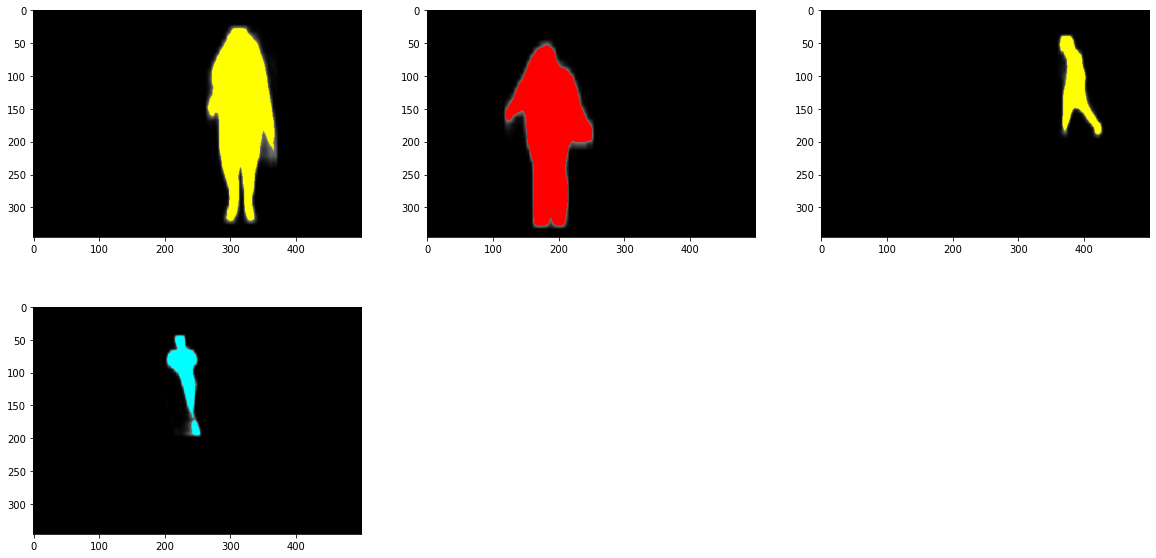

In [ ]:
plt.figure(figsize=(20,10))
columns = 3
color_preds = []

n_masks = prediction[0]['masks'].shape[0]
for index in range(n_masks):
  im = prediction[0]['masks'][index, 0].mul(255).byte().cpu().numpy()
  im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
  im[np.all(im >= (127,127,127), axis=-1)] = random.choice(colors)
  color_preds.append(im)
  plt.subplot(n_masks / columns + 1, columns, index + 1)
  plt.imshow(im, cmap="gray")

## add random color to the prected masks and show them on the image

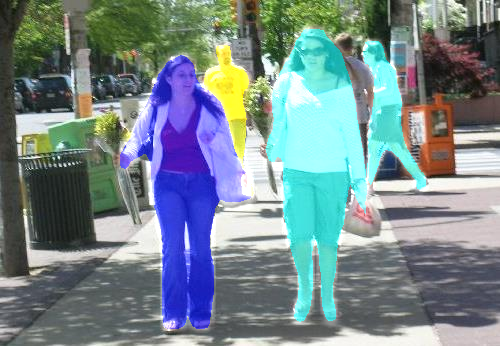

In [ ]:
result = img_cv
for j in range(len(color_preds)):
  result = cv2.addWeighted(result,1.0,color_preds[j],0.6,0)


from google.colab.patches import cv2_imshow
cv2_imshow(result)

In [ ]:
# import cv2

# PIL_predictions = []
# np_predictions = []

# pred_masks = torch.squeeze(prediction[0]['masks']).permute(1, 2, 0)

# # image.crop((box[0], box[1], box[2], box[3])
# mask_predictions = pred_masks.mul(255).cpu().numpy()

# mask_predictions = mask_predictions.astype(np.uint8)

# pred_1 = mask_predictions[:, :, 0]

# print("mask predictions size", mask_predictions.shape)

# # for i in range(mask_predictions.shape[2]):
# #   PIL_predictions.append(Image.fromarray(mask_predictions[:, :, i]))

# for i in range(mask_predictions.shape[2]):
#   np_predictions.append(mask_predictions[:, :, i])

# # im1 = PIL_predictions[0].save("/content/geeks.jpg")

mask predictions size (346, 500, 4)


In [ ]:
import random
# Red: RGB(255,0,0)
# Green: RGB(0,255,0)
# Blue: RGB(0,0,255)
# Yellow: RGB(255,255,0)
# Magenta: RGB(255,0,255)
# Cyan: RGB(0,255,255)
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
yellow = (255,255,0)
magenta = (255,0,255)
cyan = (0,255,255)

colors = [red, green, blue, yellow, magenta, cyan]

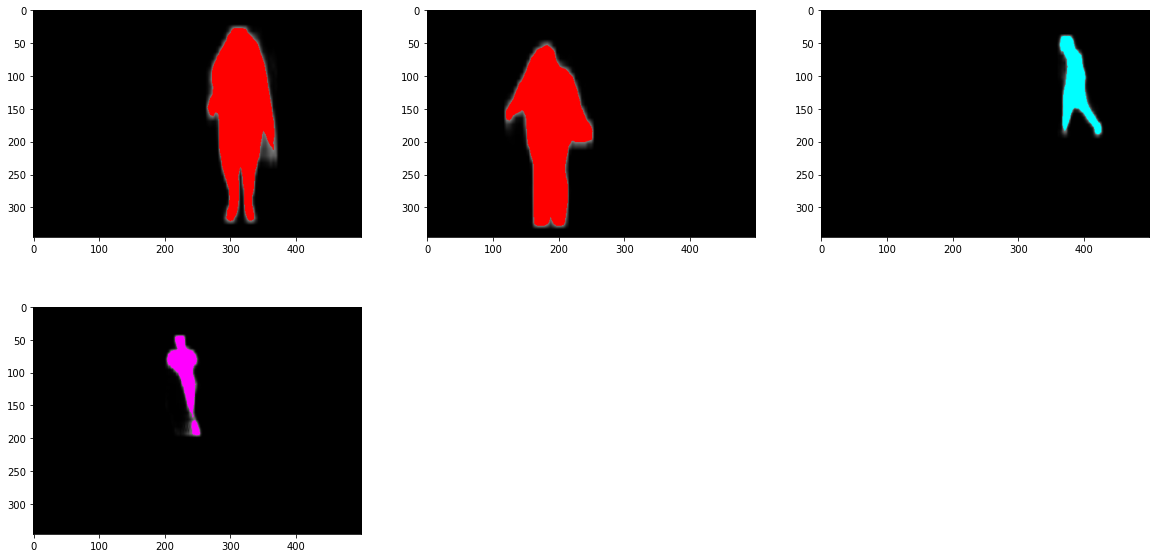

In [ ]:
plt.figure(figsize=(20,10))
columns = 3

n_masks = len(color_preds)
for index in range(n_masks):
  im = color_preds[index]
  plt.subplot(n_masks / columns + 1, columns, index + 1)
  plt.imshow(im, cmap="gray")

In [ ]:
# pred_1 = cv2.cvtColor(pred_1,cv2.COLOR_GRAY2RGB)
# pred_1[np.all(pred_1 >= (127,127,127), axis=-1)] = (0,255,0)

In [ ]:
# plt.imshow(pred_1)

True

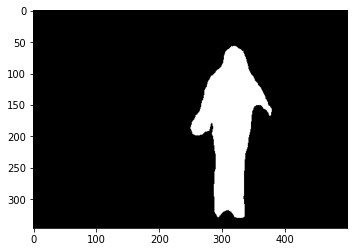

In [ ]:

img = cv2.imread('/content/geeks.jpg', 0) 

ret,thresh1 = cv2.threshold(img,180,255,cv2.THRESH_BINARY)

plt.imshow(thresh1, cmap='gray')

cv2.imwrite("/content/result.png",thresh1)



## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 





---



# GAN part
### Now that we have our Mask-RCNN Model that is ready and trained on the dataset, we try to improve its prediction performances by adversarial approach.


#### Creation of discriminator network

In [ ]:
###################################
## -------- Configs ------------ ##
###################################

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # input is (nc) x 64 x 64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 2 x 2

            nn.Conv2d(ndf * 16, 1, 2, 1, 0, bias=False),
            nn.Sigmoid() # use this for BCE loss
            #nn.Linear(1, 1) # use this in Least Square GAN
        )

    def forward(self, input):
        return self.main(input)

### Weight init

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
# print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, 

In [ ]:
from torchsummary import summary

summary(netD, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,024
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 128, 16, 16]         262,144
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         LeakyReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         524,288
      BatchNorm2d-10            [-1, 256, 8, 8]             512
        LeakyReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

### Loss function and optimizer

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# # Initialize MSELoss function
# # mse = nn.MSELoss()
# criterion = nn.MSELoss()

#Initialize loss function for the Mask generator training
mae = nn.L1Loss() # MAE loss

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Optimizer for the discriminator:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# optimizer for the generator 
# optimizer = optim.Adam(params, lr=lr, betas=(beta1, 0.999))

optimizer = torch.optim.SGD(params, lr=lr,
                            momentum=0.9, weight_decay=0.00002)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)



## Adversarial training

In [ ]:
import torch.nn.functional as nnf

In [ ]:
!cp '/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/utilities.py' ./


In [ ]:
from utilities import compute_matches, trim_zeros, compute_overlaps_masks

In [ ]:
import torchvision.transforms as transforms

tensor_converter = transforms.ToTensor() 

GPU = False

if torch.cuda.is_available():
  GPU = True

### Non paired training

In [ ]:
from matplotlib.lines import Line2D 
from time import sleep
from IPython.display import clear_output

In [ ]:
## The following function is used to check that the gradient flow is
# working while the network is trained. If called it shows a plot
# representing the gradient flow for the network layers

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
D_mask_losses = []
Gen_losses = []
iters = 0
masks = []
b_size = 1

LAMBDA = 100

epoch = 0

num_epochs = 20

#errD_masks = torch.zeros((1), device=device, dtype=dtype)
#errG_tot = torch.zeros((1), device=device, dtype=dtype)

print("Starting Training Loop...")
# For each epoch
for epoch in range(epoch, num_epochs+epoch):
    # For each batch in the dataloader
    #for k, data in enumerate(data_loader_test, 0):
    for k, data in enumerate(data_loader_test, 0):

        # get the image
        tensor_image = data[0][0]
        # get the corresponding gt boxes
        gt_boxes = data[1][0]["boxes"].cpu().numpy()
        # get the corresponding gt masks
        gt_masks = data[1][0]["masks"]
        tensor_gt_labels = data[1][0]["labels"]
        ## -----------------------
        # generate mask predictions using the Mask-RCNN model
        model.eval() # put the model in evaluation mode

        prediction = model([tensor_image.to(device)])

        ## IMPORTANT restore the model in training mode
        model.train()
        # -------
        pred_masks = prediction[0]["masks"] # tensor predicted masks
        # save predictions and extract each corresponding boxes
        pred_boxes = prediction[0]["boxes"].cpu().detach().numpy()
        # save predicted scores and labels
        pred_labels = prediction[0]["labels"].cpu().numpy()
        pred_scores = prediction[0]["scores"].cpu().detach().numpy()

        # ################ Compute Matches ######################
        ## 
        # convert image tensor in PIL image
        image = Image.fromarray(tensor_image.mul(255).permute(1, 2, 0).byte().numpy())
        # get the corresponding gt numpy masks
        gt_numpy_masks = data[1][0]["masks"].mul(255).permute(1, 2, 0).cpu().numpy()
        ## -----------------------
        pred_numpy_masks = torch.squeeze(prediction[0]["masks"], dim=1).permute(1, 2, 0).cpu().detach().numpy()
        ## --------------------------------
        gt_match, pred_match, overlaps = compute_matches(gt_boxes, tensor_gt_labels, gt_numpy_masks, 
                                                         pred_boxes, pred_labels, pred_scores, pred_numpy_masks)
        valid_gt_match = [] # initialize list before every iteration to avoid errors
        valid_gt_elems = []
        index = 0 # initialize i before every iteration to avoid errors
        elem = None # initialize i before every iteration to avoid errors
        for index, elem in enumerate(gt_match):
          if np.int(elem) != -1:
            valid_gt_match.append(np.int(elem))
            valid_gt_elems.append(index)
        
        # ################ END - Compute Matches ######################


        # inizialize gradients at each iteration
        netD.zero_grad()

        # # uncomment to block discriminator training in even epochs 
        # netD.train()
        # if (k%2 == 0):
        #   netD.train(False)

        
        real_errors = []
        fake_errors = []
        gen_losses = []

        errD_masks = 0
        errG_tot = 0

        real_batch = torch.empty(gt_masks.shape[0], 1, 128, 128)
        fake_batch = torch.empty(pred_masks.shape[0], 1, 128, 128)

        i = 0 # initialize i before every iteration to avoid errors
        for i in range(gt_masks.shape[0]):

          real_mask = gt_masks[i ,:, :] # get the i-th mask
          # add channel
          real_mask.unsqueeze_(0)
          normalized_real_mask = (real_mask - 0.5).div(0.5) # normalize the mask in -1,1
          # add batch dimension
          # normalized_real_mask.unsqueeze_(0)

          real_box = gt_boxes[i, :]
          top = int(real_box[1])
          left = int(real_box[0])
          heigth = int(real_box[3] - real_box[1])
          width = int(real_box[2] - real_box[0])

          ## REAL DATA
          # crop real mask with real boxes
          cropped_mask = torchvision.transforms.functional.crop(normalized_real_mask, top, left, heigth, width)
          # resize the cropped mask to 128x128
          tensor_mask = transforms.functional.resize(cropped_mask, [128,128])

          real_batch[i] = tensor_mask

        
        # train with reals
        if (np.random.uniform()>0.95): #introduce a low probability of noisy labels)
          label = torch.FloatTensor(gt_masks.shape[0], ).uniform_(0.0, 0.3)
          #label = torch.full((gt_masks.shape[0],), fake_label, dtype=torch.float, device=device)
        else:
          label = torch.FloatTensor(gt_masks.shape[0], ).uniform_(0.7, 1.2)
          #label = torch.full((gt_masks.shape[0],), real_label, dtype=torch.float, device=device)

        if (GPU == True):
          label, real_batch = label.cuda(), real_batch.cuda()
        output = netD(real_batch).view(-1)
        # Calculate loss on all-real batch

        errD_real_mask = criterion(output, label)
        #print("error real masks ",errD_real_mask)
        #print("error real requires grad ",errD_real_mask.requires_grad)

        errD_real_mask.backward()

        D_x_mask_real = output.mean().item()
          
        ##  ----- TRAIN WITH FAKES -----------

        j = 0
        for j in range(pred_masks.shape[0]):
          fake_mask = pred_masks[j, :, : ,:]
          normalized_fake_mask = (fake_mask - 0.5).div(0.5) # normalize the mask in -1,1
          # print("normalized fake mask shape ", normalized_fake_mask.shape )

          fake_box = pred_boxes[j, :]
          top = int(fake_box[1])
          left = int(fake_box[0])
          heigth = int(fake_box[3] - fake_box[1])
          width = int(fake_box[2] - fake_box[0])

          if ((heigth <= 1) or (width <= 1)):
            continue

          # crop using the predicted boxes
          cropped_fake_mask = torchvision.transforms.functional.crop(normalized_fake_mask, top, left, heigth, width)
          # print("cropped fake mask shape ", cropped_fake_mask.shape )
          # resize the cropped mask to 128x128
          tensor_fake_mask = transforms.functional.resize(cropped_fake_mask, [128,128])
          #print("tensor fake mask shape ", tensor_fake_mask.shape)
          fake_batch[j] = tensor_fake_mask

        
        # train with fakes
        if (np.random.uniform()>0.95): #introduce a low probability of noisy labels)
          #label = torch.full((pred_masks.shape[0],), real_label, dtype=torch.float, device=device)
          label = torch.FloatTensor(pred_masks.shape[0], ).uniform_(0.7, 1.2)
        else:
          label = torch.FloatTensor(pred_masks.shape[0], ).uniform_(0.0, 0.3)
          #label = torch.full((pred_masks.shape[0],), fake_label, dtype=torch.float, device=device)

        if (GPU == True):
          label, fake_batch = label.cuda(), fake_batch.cuda()
        output = netD(fake_batch.detach()).view(-1)
        # Calculate loss on all-fake batch

        errD_fake_mask = criterion(output, label)
        #print("error fake masks ",errD_fake_mask)
        #print("error fake requires grad ",errD_fake_mask.requires_grad)
        errD_fake_mask.backward()

        D_x_mask_fake = output.mean().item()

        # Update D
        optimizerD.step()


        # --------------------
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model.zero_grad()

        real_matched_batch = torch.empty(len(valid_gt_match), 1, 128, 128)
        fake_matched_batch = torch.empty(len(valid_gt_match), 1, 128, 128)
        count = 0

        h = 0
        for h in range(pred_masks.shape[0]):
          

          matching = False
          ### Chech if there is matching with GT ###
          if (h in valid_gt_match): # check if there is matching
            matching = True
            # we have a prediction - gt correspondence
            # get index elem of h in valid gt elems
            corresponding_index = valid_gt_match.index(h)
            # use the index to find valid gt index in gt masks
            valid_gt_index = valid_gt_elems[corresponding_index]
            # get the mask
            real_mask = real_batch[valid_gt_index] # get the i-th real mask
            fake_mask = fake_batch[h]

            real_matched_batch[count] = real_mask
            fake_matched_batch[count] = fake_mask

            count += 1

        # set label to true label
        label = torch.full((pred_masks.shape[0],), real_label, dtype=torch.float, device=device)
        if (GPU == True):
          real_matched_batch, fake_matched_batch, label = real_matched_batch.cuda(), fake_matched_batch.cuda(), label.cuda()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        # compute output for Mask
        outputM = netD(fake_batch).view(-1)

        # Calculate G's loss based on this output
        if (matching == True):
          errG_mask = criterion(outputM, label) + LAMBDA*mae(real_matched_batch, fake_matched_batch)
        else:
          errG_mask = criterion(outputM, label)
            
        # Calculate gradients for G
        errG_mask.backward()
        # plot_grad_flow(model.named_parameters()) # plots the gradient flow
        optimizer.step()
        lr_scheduler.step()
          
        D_G_mask = outputM.mean().item()

        errD_masks = float(errD_real_mask+errD_fake_mask)
        errG_tot = float(errG_mask)

        # Output training stats
        if k % 5 == 0:
          print('[%d/%d][%d/%d]\tLoss_D_mask: %.4f\tLoss_G: %.4f\tD(x_real): %.4f\tD(x_fake): %.4f\t'
          % (epoch, num_epochs, k, len(data_loader_test),
             errD_masks, errG_tot, D_x_mask_real, D_x_mask_fake))

        D_mask_losses.append(errD_masks)
        Gen_losses.append(errG_tot)

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0/20][0/75]	Loss_D_mask: 1.6720	Loss_G: 0.2281	D(x_real): 0.3583	D(x_fake): 0.3558	
[0/20][5/75]	Loss_D_mask: 1.6434	Loss_G: 3.9290	D(x_real): 0.5867	D(x_fake): 0.7182	
[0/20][10/75]	Loss_D_mask: 7.5544	Loss_G: 0.4258	D(x_real): 0.9992	D(x_fake): 0.9967	
[0/20][15/75]	Loss_D_mask: 1.4277	Loss_G: 1.9927	D(x_real): 0.4229	D(x_fake): 0.1688	
[0/20][20/75]	Loss_D_mask: 1.4910	Loss_G: 0.9431	D(x_real): 0.4858	D(x_fake): 0.1711	
[0/20][25/75]	Loss_D_mask: 1.7328	Loss_G: 0.7561	D(x_real): 0.5965	D(x_fake): 0.5781	
[0/20][30/75]	Loss_D_mask: 2.8991	Loss_G: 0.0727	D(x_real): 0.0618	D(x_fake): 0.0585	
[0/20][35/75]	Loss_D_mask: 1.1155	Loss_G: 3.5051	D(x_real): 0.6860	D(x_fake): 0.1545	
[0/20][40/75]	Loss_D_mask: 1.8785	Loss_G: 2.2211	D(x_real): 0.9478	D(x_fake): 0.9330	
[0/20][45/75]	Loss_D_mask: 0.6420	Loss_G: 20.2813	D(x_real): 0.6535	D(x_fake): 0.2051	
[0/20][50/75]	Loss_D_mask: 2.4878	Loss_G: 1.6014	D(x_real): 0.2605	D(x_fake): 0.1822	
[0/20][55/75]	Loss_D_mask: 3.3240	Loss_G: 2.1934	D(x_re

In [ ]:
# PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/GAN_generator_pennfudan_75imgs_epoch"+str(epoch)
PATH = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/saved_models/GAN_generator_BCE_pennfudan_75imgs_100%_epoch"+str(epoch)

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            }, PATH)

In [ ]:

# pick one image from the test set
img, targets = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

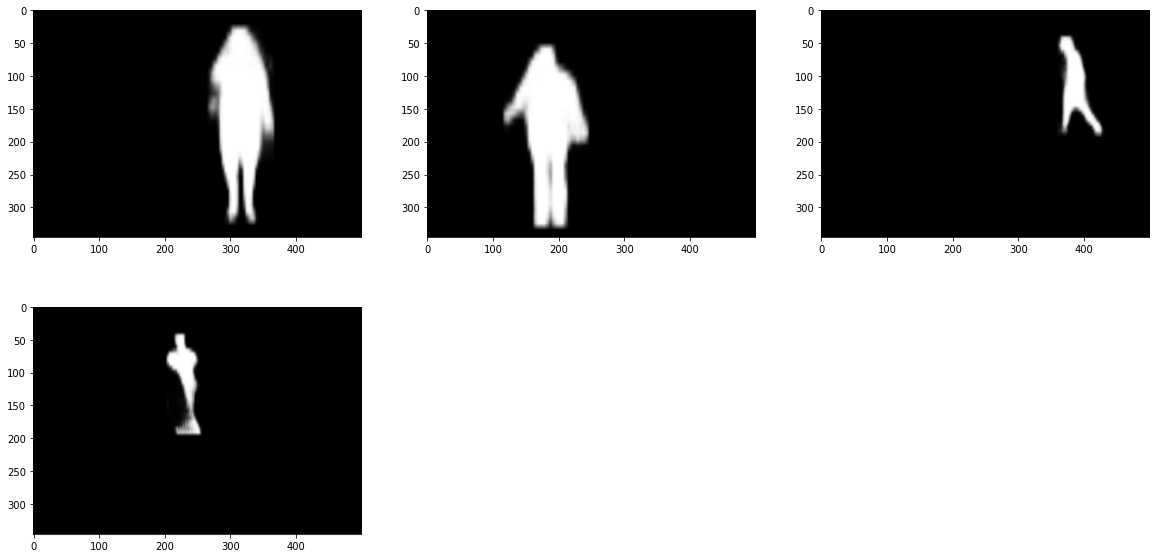

In [ ]:
plt.figure(figsize=(20,10))
columns = 3

n_masks = prediction[0]['masks'].shape[0]
for index in range(n_masks):
  im = prediction[0]['masks'][index, 0].mul(255).byte().cpu().numpy()
  plt.subplot(n_masks / columns + 1, columns, index + 1)
  plt.imshow(im, cmap="gray")

 --- GROUND TRUTH Masks ---


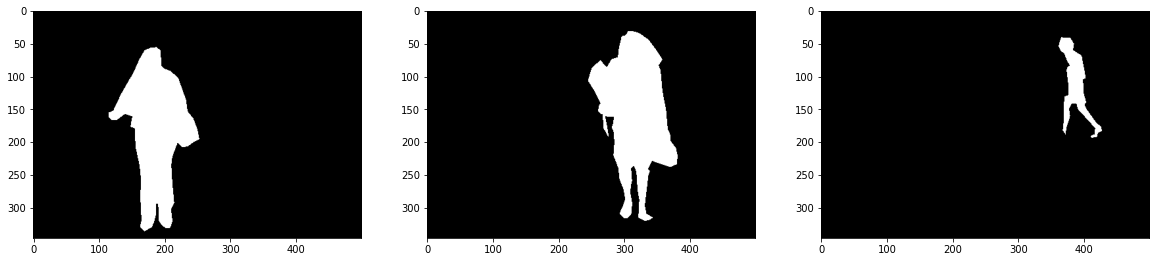

In [ ]:
# real masks plot

plt.figure(figsize=(20,10))
columns = 3

print(" --- GROUND TRUTH Masks ---")
n_masks = targets['masks'].shape[0]
for index in range(n_masks):
  im = targets['masks'][index].mul(255).byte().cpu().numpy()
  plt.subplot(n_masks / columns + 1, columns, index + 1)
  plt.imshow(im, cmap="gray")



---



In [ ]:
"""Evaluate the model"""
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

FILENAME = "/content/drive/MyDrive/Thesis/Pythorch Mask-RCNN/results/PennFudan/"

# evaluate model performances
with open(FILENAME+'GAN_mask_BCE_75imgs_100%_epoch_'+str(epoch)+'.txt', 'w') as f: # for BCE GAN maskrcnn model
#with open(FILENAME+'GAN_mask_MSE_epoch_'+str(epoch)+'.txt', 'w') as f: # for MSE GAN maskrcnn model

    sys.stdout = f # Change the standard output to the file we created.
    # # evaluate model on evaluation dataset
    evaluate(model, data_loader_evaluation, device=device)
    sys.stdout = original_stdout # Reset the standard output to its original value

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




---



### plot of the losses during training

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Gen_losses,label="G")
plt.plot(D_mask_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()